In [33]:
import pandas as pd
import numpy as np
from datasets import load_dataset
import matplotlib.pyplot as plt
from tqdm import tqdm
import re
import warnings

warnings.filterwarnings('ignore')

In [34]:
# Загружаем датасет
dataset = load_dataset("inkoziev/jokes_dialogues")
df = pd.DataFrame(dataset['train'])

print(f"Реплик: {len(df)}")
print(f"Уникальных анекдотов: {df['src_hash'].nunique()}")

# Базовая статистика
print(f"\nСтатистика:")
print(f"  Средняя длина реплики: {df['utterance'].str.len().mean():.1f} символов")
print(f"  Средняя длина контекста: {df['context'].str.len().mean():.1f} символов")
print(f"  Средний диалог: {df.groupby('src_hash').size().mean():.1f} реплик")

Реплик: 114579
Уникальных анекдотов: 49321

Статистика:
  Средняя длина реплики: 44.6 символов
  Средняя длина контекста: 170.7 символов
  Средний диалог: 2.3 реплик


In [35]:
# === ОТЧИСТКА  ===
initial_count = len(df)

# 1. Удаляем слишком короткие реплики (≤3 символа)
df = df[df['utterance'].str.len() > 3].copy()
removed_short = initial_count - len(df)
print(f"Удалены короткие реплики (≤3 символа): {removed_short}")

# 2. Удаляем слишком длинные реплики (>1000 символов - явные выбросы)
current_count = len(df)
df = df[df['utterance'].str.len() <= 1000].copy()
removed_long = current_count - len(df)
print(f"Удалены длинные реплики (>1000 символов): {removed_long}")

# 3. Удаляем пустые контексты
current_count = len(df)
df = df[df['context'].str.len() > 0].copy()
removed_empty = current_count - len(df)
print(f"Удалены пустые контексты: {removed_empty}")

print(f"\nОсталось реплик: {len(df)} ({len(df)/initial_count*100:.1f}%)")
print(f"Удалено всего: {initial_count - len(df)} ({(initial_count - len(df))/initial_count*100:.1f}%)")

Удалены короткие реплики (≤3 символа): 907
Удалены длинные реплики (>1000 символов): 7
Удалены пустые контексты: 0

Осталось реплик: 113665 (99.2%)
Удалено всего: 914 (0.8%)


### Методы очистки

1. Агрессивная:
- Теряет информацию о регистре (важно для начала предложений)
- Удаляет числа (могут быть частью шутки: "сколько стоит?", "в 5 лет...")
- Удаляет эмоциональную пунктуацию (!!!, ???, ...)
- Может ухудшить качество для предобученных моделей

2. Минимальная нормализация:
- Сохраняет всю смысловую информацию
- Предобученные токенизаторы (ruGPT, GPT-2) обучены на "сыром" тексте
- Регистр важен для качества генерации
- Числа и пунктуация несут смысл в диалогах
- Формально не следует букве задания

Выбор: минимальная нормализация

Обоснование:
- Современные трансформерные модели (ruGPT-3, DialoGPT) обучены на текстах 
  с сохранением регистра, чисел и пунктуации
- Агрессивная очистка может снизить качество генерации
- В диалогах регистр и пунктуация несут эмоциональную окраску
- Токенизатор модели уже умеет работать с "сырым" текстом

In [36]:
# === ПРЕДОБРАБОТКА ===

# Функция 1: Агрессивная очистка
def preprocess_aggressive(text):
    """
    Агрессивная очистка согласно требованиям задания:
    - Приведение к lowercase
    - Удаление чисел
    - Удаление спецсимволов
    """
    if pd.isna(text):
        return ""
    
    text = str(text)
    # Приводим к нижнему регистру
    text = text.lower()
    # Удаляем числа
    text = re.sub(r'\d+', '', text)
    # Удаляем спецсимволы (оставляем только буквы, пробелы и базовую пунктуацию)
    text = re.sub(r'[^а-яёa-z\s\.\,\!\?\-]', '', text)
    # Нормализуем множественные пробелы
    text = re.sub(r'\s+', ' ', text)
    # Убираем пробелы в начале/конце
    text = text.strip()
    return text

# Функция 2: Минимальная нормализация
def preprocess_minimal(text):
    """
    Минимальная предобработка:
    - Нормализация пробелов
    - Удаление лишних переносов строк
    - Сохранение регистра, чисел и пунктуации
    """
    if pd.isna(text):
        return ""
    
    text = str(text)
    # Заменяем переносы строк на пробелы
    text = text.replace('\n', ' ')
    # Нормализуем множественные пробелы
    text = re.sub(r'\s+', ' ', text)
    # Убираем пробелы в начале/конце
    text = text.strip()
    return text

# Берем разнообразные примеры
example_indices = [10, 100, 500, 1000, 5000]
examples = df.iloc[example_indices]['utterance']

for i, text in enumerate(examples, 1):
    print(f"Пример {i}:")
    print(f"  Оригинал:    '{text}'")
    print(f"  Агрессивная: '{preprocess_aggressive(text)}'")
    print(f"  Минимальная: '{preprocess_minimal(text)}'")
    print()

# Применяем минимальную нормализацию
df['utterance_clean'] = df['utterance'].apply(preprocess_minimal)
df['context_clean'] = df['context'].apply(preprocess_minimal)

Пример 1:
  Оригинал:    'Ну ты тяжелый, бля!!!'
  Агрессивная: 'ну ты тяжелый, бля!!!'
  Минимальная: 'Ну ты тяжелый, бля!!!'

Пример 2:
  Оригинал:    'Ну, как, как...'
  Агрессивная: 'ну, как, как...'
  Минимальная: 'Ну, как, как...'

Пример 3:
  Оригинал:    'Брюнетку?'
  Агрессивная: 'брюнетку?'
  Минимальная: 'Брюнетку?'

Пример 4:
  Оригинал:    'О, четвертый был член правительства. Как он ни старался, все у него получалось через жопу.'
  Агрессивная: 'о, четвертый был член правительства. как он ни старался, все у него получалось через жопу.'
  Минимальная: 'О, четвертый был член правительства. Как он ни старался, все у него получалось через жопу.'

Пример 5:
  Оригинал:    'А если одну Снегурочку?'
  Агрессивная: 'а если одну снегурочку?'
  Минимальная: 'А если одну Снегурочку?'



In [37]:
# === ПОДГОТОВКА ПАР (CONTEXT → UTTERANCE) ===

# Для диалоговой модели нужны только реплики с контекстом (reply_num >= 2)
df_with_context = df[df['reply_num'] >= 2].copy()

print(f"Реплик с контекстом (reply_num >= 2): {len(df_with_context)}")
print(f"Это {len(df_with_context)/len(df)*100:.1f}% от отфильтрованных данных")

# Создаем финальный датасет с очищенными текстами
train_data = df_with_context[['context_clean', 'utterance_clean']].copy()
train_data.columns = ['input', 'output']

print(f"\nПодготовлено пар для обучения: {len(train_data)}")

# Примеры финальных пар
print("\n" + "=" * 80)
print("ПРИМЕРЫ ПАР (CONTEXT → UTTERANCE)")
print("=" * 80)

for i in range(5):
    sample = train_data.iloc[i]
    print(f"\nПример {i+1}:")
    print(f"  INPUT:  {sample['input'][:100]}...")
    print(f"  OUTPUT: {sample['output']}")

Реплик с контекстом (reply_num >= 2): 66061
Это 58.1% от отфильтрованных данных

Подготовлено пар для обучения: 66061

ПРИМЕРЫ ПАР (CONTEXT → UTTERANCE)

Пример 1:
  INPUT:  - Ты верующий? - Частично....
  OUTPUT: В смысле, в бога веришь, а в храм не ходишь?

Пример 2:
  INPUT:  - Ты верующий? - Частично. - В смысле, в бога веришь, а в храм не ходишь?...
  OUTPUT: В смысле, масленицу справляю, а пост не соблюдаю.

Пример 3:
  INPUT:  Разговаривают две подруги. - Как у тебя насчет контрацептивов?...
  OUTPUT: Ах, этот гандон так и не позвонил.

Пример 4:
  INPUT:  Пособие для кредитных специалистов Адаптация вопросов кредитного интервью применительно к малому биз...
  OUTPUT: Навар с этой точки на другие кидаете? А чтоб курей здесь закоптить, а там...

Пример 5:
  INPUT:  Стандартная ситуация. Ночь, звонок в дверь. - Это муж, прячься!...
  OUTPUT: Куда?


In [38]:
# === РАЗДЕЛЕНИЕ НА TRAIN/VAL/TEST ===
from sklearn.model_selection import train_test_split

# Устанавливаем random_state для воспроизводимости
RANDOM_STATE = 42

# Сначала отделяем test (10%)
train_val, test = train_test_split(
    train_data, 
    test_size=0.1, 
    random_state=RANDOM_STATE
)

# Затем из оставшихся 90% делаем train (80% от всех) и val (10% от всех)
train, val = train_test_split(
    train_val, 
    test_size=0.111,  # 0.111 * 0.9 ≈ 0.1
    random_state=RANDOM_STATE
)

print(f"\nРазделение данных:")
print(f"  Train: {len(train):6} пар ({len(train)/len(train_data)*100:.1f}%)")
print(f"  Val:   {len(val):6} пар ({len(val)/len(train_data)*100:.1f}%)")
print(f"  Test:  {len(test):6} пар ({len(test)/len(train_data)*100:.1f}%)")
print(f"  {'─'*40}")
print(f"  Total: {len(train_data):6} пар (100.0%)")

# Сохраняем во временные CSV
train.to_csv('train_data.csv', index=False)
val.to_csv('val_data.csv', index=False)
test.to_csv('test_data.csv', index=False)

print("\nДанные сохранены в CSV файлы:")
print("- train_data.csv")
print("- val_data.csv")
print("- test_data.csv")


Разделение данных:
  Train:  52854 пар (80.0%)
  Val:     6600 пар (10.0%)
  Test:    6607 пар (10.0%)
  ────────────────────────────────────────
  Total:  66061 пар (100.0%)

Данные сохранены в CSV файлы:
- train_data.csv
- val_data.csv
- test_data.csv


In [39]:
# Импортируем GPT2Tokenizer
from transformers import GPT2Tokenizer

MODEL_NAME = "sberbank-ai/rugpt3small_based_on_gpt2"

print(f"Загрузка токенизатора: {MODEL_NAME}")

tokenizer = GPT2Tokenizer.from_pretrained(MODEL_NAME)

print("\nТокенизатор загружен:")
print("Model: {MODEL_NAME}")
print("Type: GPT2Tokenizer")
print(f"Vocab size: {len(tokenizer):,}")
print(f"PAD token: '{tokenizer.pad_token}' (id: {tokenizer.pad_token_id})")
print(f"EOS token: '{tokenizer.eos_token}' (id: {tokenizer.eos_token_id})")
print(f"BOS token: '{tokenizer.bos_token}' (id: {tokenizer.bos_token_id})")

Загрузка токенизатора: sberbank-ai/rugpt3small_based_on_gpt2

Токенизатор загружен:
Model: {MODEL_NAME}
Type: GPT2Tokenizer
Vocab size: 50,257
PAD token: '<pad>' (id: 0)
EOS token: '</s>' (id: 2)
BOS token: '<s>' (id: 1)


In [40]:
# === ТЕСТИРОВАНИЕ ТОКЕНИЗАТОРА НА ПРИМЕРАХ ===

# Берем 5 примеров
test_samples = train.head(5)

for idx, (i, row) in enumerate(test_samples.iterrows(), 1):
    input_text = row['input']
    output_text = row['output']
    
    # Токенизируем
    input_tokens = tokenizer(input_text, return_tensors=None)
    output_tokens = tokenizer(output_text, return_tensors=None)
    
    print(f"\nПример {idx}:")
    print(f"  INPUT текст ({len(input_text)} символов):")
    print(f"    {input_text[:80]}...")
    print(f"  INPUT токены: {len(input_tokens['input_ids'])}")
    print(f"    Первые 10 токенов: {input_tokens['input_ids'][:10]}")
    
    print(f"  OUTPUT текст ({len(output_text)} символов):")
    print(f"    {output_text}")
    print(f"  OUTPUT токены: {len(output_tokens['input_ids'])}")
    print(f"    Токены: {output_tokens['input_ids']}")
    
    # Декодируем обратно для проверки
    decoded = tokenizer.decode(output_tokens['input_ids'])
    print(f"  Декодировано обратно: {decoded}")


Пример 1:
  INPUT текст (480 символов):
    Поехали два депутата городской думы на рыбалку. Порыбачили, сели выпить, покушат...
  INPUT токены: 119
    Первые 10 токенов: [672, 647, 23240, 1272, 20691, 9207, 26769, 309, 5904, 33727]
  OUTPUT текст (72 символов):
    Нет, Миш. Совпадения, не совпадения, а новый морг я уже успел пообещать…
  OUTPUT токены: 23
    Токены: [9256, 16, 2230, 301, 18, 2231, 1896, 427, 16, 322, 17486, 427, 16, 367, 3655, 1948, 297, 417, 726, 5354, 9196, 4138, 655]
  Декодировано обратно: Нет, Миш. Совпадения, не совпадения, а новый морг я уже успел пообещать…

Пример 2:
  INPUT текст (266 символов):
    В баре трое охотников рассказывают друг другу о своих успехах на сафари. Первый:...
  INPUT токены: 69
    Первые 10 токенов: [677, 32158, 9208, 31276, 25749, 702, 6527, 290, 1634, 9792]
  OUTPUT текст (69 символов):
    А на меня помчался буйвол с наставленными рогами, ну, я в него - бух!
  OUTPUT токены: 20
    Токены: [618, 309, 703, 38040, 22563, 1102, 281


СТАТИСТИКА ПО ДЛИНАМ ТОКЕНОВ

Анализ первых 5000 примеров из train...


Токенизация: 100%|██████████| 5000/5000 [00:02<00:00, 2224.51it/s]



INPUT (контекст) токены:
   Среднее:        59.6
   Медиана:        39.0
   Стд. отклонение: 66.3
   Минимум:        7
   Максимум:       1147
   75-й перцентиль: 70.0
   90-й перцентиль: 122.1
   95-й перцентиль: 165.0

OUTPUT (ответ) токены:
   Среднее:        11.6
   Медиана:        9.0
   Стд. отклонение: 10.3
   Минимум:        2
   Максимум:       225
   75-й перцентиль: 14.0
   90-й перцентиль: 21.0
   95-й перцентиль: 27.0

MAX_LENGTH:
   INPUT:  122 токенов (покрывает 90% данных)
   OUTPUT: 21 токенов (покрывает 90% данных)


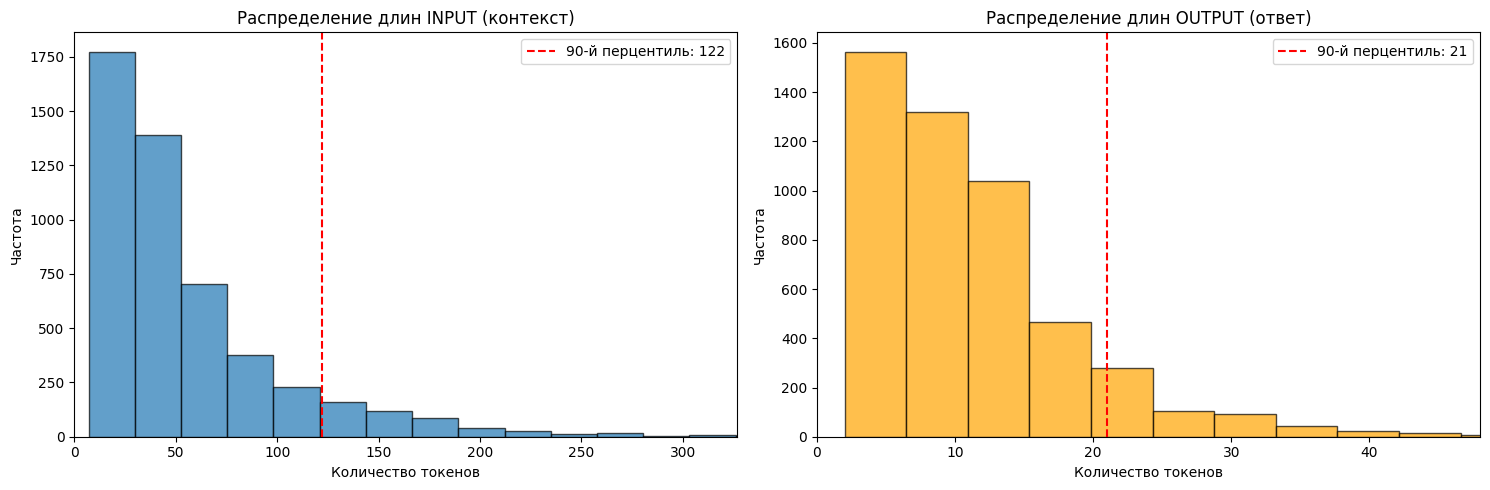


✅ График сохранен: token_lengths.png


In [41]:
# === АНАЛИЗ ДЛИН ТОКЕНОВ ===
print("\n" + "=" * 80)
print("СТАТИСТИКА ПО ДЛИНАМ ТОКЕНОВ")
print("=" * 80)

print("\nАнализ первых 5000 примеров из train...")

input_lengths = []
output_lengths = []

# Анализируем подвыборку для скорости
sample_size = min(5000, len(train))
for _, row in tqdm(train.head(sample_size).iterrows(), total=sample_size, desc="Токенизация"):
    input_tokens = tokenizer(row['input'], truncation=False)
    output_tokens = tokenizer(row['output'], truncation=False)
    input_lengths.append(len(input_tokens['input_ids']))
    output_lengths.append(len(output_tokens['input_ids']))

# Статистика
print(f"\nINPUT (контекст) токены:")
print(f"   Среднее:        {np.mean(input_lengths):.1f}")
print(f"   Медиана:        {np.median(input_lengths):.1f}")
print(f"   Стд. отклонение: {np.std(input_lengths):.1f}")
print(f"   Минимум:        {np.min(input_lengths)}")
print(f"   Максимум:       {np.max(input_lengths)}")
print(f"   75-й перцентиль: {np.percentile(input_lengths, 75):.1f}")
print(f"   90-й перцентиль: {np.percentile(input_lengths, 90):.1f}")
print(f"   95-й перцентиль: {np.percentile(input_lengths, 95):.1f}")

print(f"\nOUTPUT (ответ) токены:")
print(f"   Среднее:        {np.mean(output_lengths):.1f}")
print(f"   Медиана:        {np.median(output_lengths):.1f}")
print(f"   Стд. отклонение: {np.std(output_lengths):.1f}")
print(f"   Минимум:        {np.min(output_lengths)}")
print(f"   Максимум:       {np.max(output_lengths)}")
print(f"   75-й перцентиль: {np.percentile(output_lengths, 75):.1f}")
print(f"   90-й перцентиль: {np.percentile(output_lengths, 90):.1f}")
print(f"   95-й перцентиль: {np.percentile(output_lengths, 95):.1f}")

# Рекомендации по max_length
input_max = int(np.percentile(input_lengths, 90))
output_max = int(np.percentile(output_lengths, 90))

print(f"\nMAX_LENGTH:")
print(f"   INPUT:  {input_max} токенов (покрывает 90% данных)")
print(f"   OUTPUT: {output_max} токенов (покрывает 90% данных)")

# Визуализация
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

axes[0].hist(input_lengths, bins=50, edgecolor='black', alpha=0.7)
axes[0].axvline(input_max, color='red', linestyle='--', 
                label=f'90-й перцентиль: {input_max}')
axes[0].set_xlabel('Количество токенов')
axes[0].set_ylabel('Частота')
axes[0].set_title('Распределение длин INPUT (контекст)')
axes[0].legend()
axes[0].set_xlim(0, np.percentile(input_lengths, 99))

axes[1].hist(output_lengths, bins=50, edgecolor='black', alpha=0.7, color='orange')
axes[1].axvline(output_max, color='red', linestyle='--', 
                label=f'90-й перцентиль: {output_max}')
axes[1].set_xlabel('Количество токенов')
axes[1].set_ylabel('Частота')
axes[1].set_title('Распределение длин OUTPUT (ответ)')
axes[1].legend()
axes[1].set_xlim(0, np.percentile(output_lengths, 99))

plt.tight_layout()
plt.savefig('token_lengths.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✅ График сохранен: token_lengths.png")

In [42]:
# === ИТОГОВЫЕ ВЫВОДЫ ===
print("\n" + "=" * 80)
print("ИТОГОВЫЕ ВЫВОДЫ ПО PREPROCESSING")
print("=" * 80)

summary = f"""
PREPROCESSING ЗАВЕРШЕН

1. ЗАГРУЗКА И ФИЛЬТРАЦИЯ:
   • Загружено реплик: {initial_count:,}
   • После фильтрации: {len(df):,}
   • Удалено: {initial_count - len(df):,} ({(initial_count - len(df))/initial_count*100:.1f}%)

2. ПРЕДОБРАБОТКА ТЕКСТА:
   • Метод: Минимальная нормализация
   • Сохранен регистр, числа и пунктуация

3. ПОДГОТОВКА ДАННЫХ:
   • Всего пар (context → utterance): {len(train_data):,}
   • Train: {len(train):,} пар (80%)
   • Val:   {len(val):,} пар (10%)
   • Test:  {len(test):,} пар (10%)

4. ТОКЕНИЗАЦИЯ:
   • Модель: {MODEL_NAME}
   • Vocab size: {len(tokenizer):,} токенов
   • Рекомендуемый max_length INPUT: {input_max}
   • Рекомендуемый max_length OUTPUT: {output_max}
"""

print(summary)


ИТОГОВЫЕ ВЫВОДЫ ПО PREPROCESSING

PREPROCESSING ЗАВЕРШЕН

1. ЗАГРУЗКА И ФИЛЬТРАЦИЯ:
   • Загружено реплик: 114,579
   • После фильтрации: 113,665
   • Удалено: 914 (0.8%)

2. ПРЕДОБРАБОТКА ТЕКСТА:
   • Метод: Минимальная нормализация
   • Сохранен регистр, числа и пунктуация

3. ПОДГОТОВКА ДАННЫХ:
   • Всего пар (context → utterance): 66,061
   • Train: 52,854 пар (80%)
   • Val:   6,600 пар (10%)
   • Test:  6,607 пар (10%)

4. ТОКЕНИЗАЦИЯ:
   • Модель: sberbank-ai/rugpt3small_based_on_gpt2
   • Vocab size: 50,257 токенов
   • Рекомендуемый max_length INPUT: 122
   • Рекомендуемый max_length OUTPUT: 21

